# Machine Learning Foundation

## Section 1, Part d: Feature Engineering 

## Feature Engineering with Linear Regression: Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf

In this notebook, we will build some linear regression models to predict housing prices from this data. In particular, we will set out to improve on a baseline set of features via **feature engineering**: deriving new features from our existing data. Feature engineering often makes the difference between a weak model and a strong one.

We will use visual exploration, domain understanding, and intuition to construct new features that will be useful later in the course as we turn to prediction.

**Notebook Contents**

> 1. Simple EDA 
> 2. One-hot Encoding variables
> 3. Log transformation for skewed variables
> 4. Pair plot for features
> 5. Basic feature engineering: adding polynomial and interaction terms
> 6. Feature engineering: categories and features derived from category aggregates 

## 1. Simple EDA 

In [131]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Load the Data, Examine and Explore

In [132]:
## Load in the Ames Housing Data
datafile = "data/Ames_Housing_Data.tsv"
df = pd.read_csv(datafile, sep='\t')

In [133]:
## Examine the columns, look at missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [134]:
df_missing = df[df.columns[df.isnull().any()]]
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    2440 non-null   float64
 1   Alley           198 non-null    object 
 2   Mas Vnr Type    1155 non-null   object 
 3   Mas Vnr Area    2907 non-null   float64
 4   Bsmt Qual       2850 non-null   object 
 5   Bsmt Cond       2850 non-null   object 
 6   Bsmt Exposure   2847 non-null   object 
 7   BsmtFin Type 1  2850 non-null   object 
 8   BsmtFin SF 1    2929 non-null   float64
 9   BsmtFin Type 2  2849 non-null   object 
 10  BsmtFin SF 2    2929 non-null   float64
 11  Bsmt Unf SF     2929 non-null   float64
 12  Total Bsmt SF   2929 non-null   float64
 13  Electrical      2929 non-null   object 
 14  Bsmt Full Bath  2928 non-null   float64
 15  Bsmt Half Bath  2928 non-null   float64
 16  Fireplace Qu    1508 non-null   object 
 17  Garage Type     2773 non-null   o

In [135]:
# Notice the distance between the 75th percentile and the max value
df['Gr Liv Area'].describe()

count    2930.000000
mean     1499.690444
std       505.508887
min       334.000000
25%      1126.000000
50%      1442.000000
75%      1742.750000
max      5642.000000
Name: Gr Liv Area, dtype: float64

<Axes: >

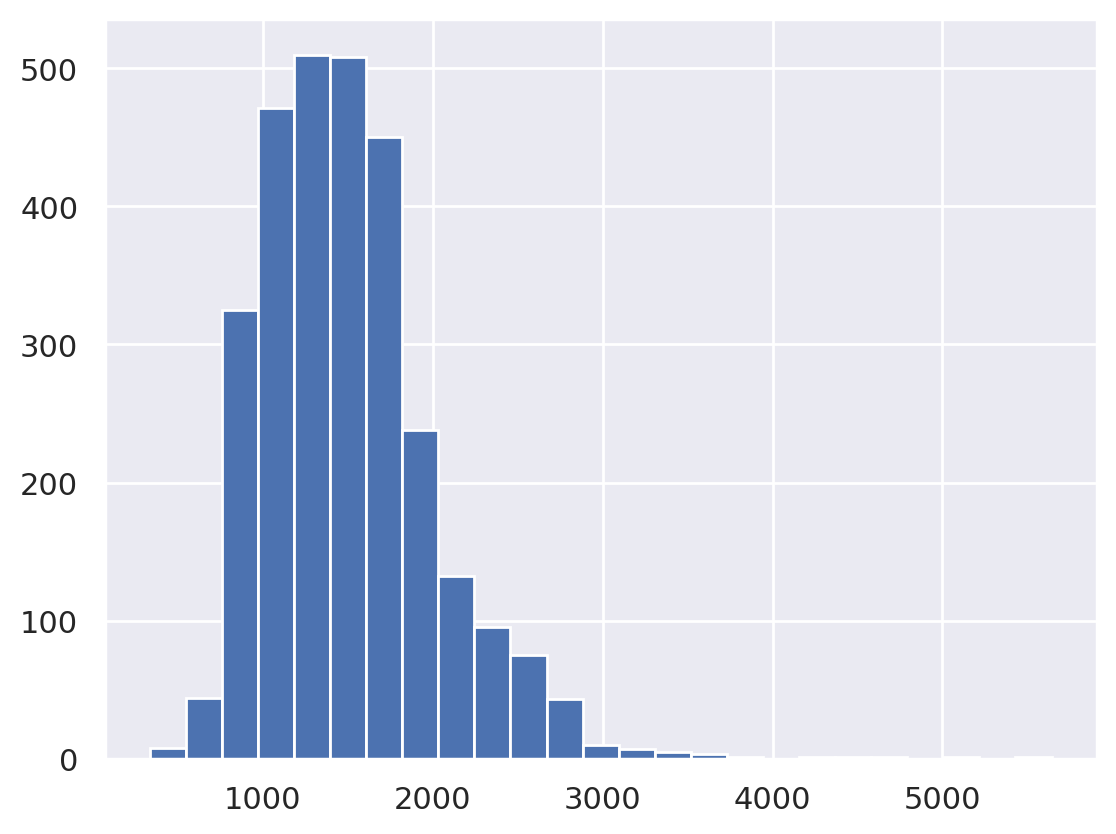

In [136]:
df['Gr Liv Area'].hist(bins=25)

In [137]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area'] <= 4000,:]
print("Number of rows in the data:", df.shape[0])

print("Number of columns in the data:", df.shape[1])
data = df.copy() # Keep a copy our original data 

Number of rows in the data: 2925
Number of columns in the data: 82


In [138]:
# A quick look at the data:
df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [139]:
# We drop columnds for which every value is unique (e.g. 'Order' and 'PID')
# Columns such as unique identifiers do not contain any information useful for prediction
df.drop(['Order', 'PID'], axis=1, inplace=True)

### Log transforming skew variables

In [140]:
df.select_dtypes('number').columns

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

### One-hot encoding for dummy variables:

In [141]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = df.dtypes[df.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

df[one_hot_encode_cols].head().T

0        1        2        3        4
MS Zoning            RL       RH       RL       RL       RL
Street             Pave     Pave     Pave     Pave     Pave
Alley               NaN      NaN      NaN      NaN      NaN
Lot Shape           IR1      Reg      IR1      Reg      IR1
Land Contour        Lvl      Lvl      Lvl      Lvl      Lvl
Utilities        AllPub   AllPub   AllPub   AllPub   AllPub
Lot Config       Corner   Inside   Corner   Corner   Inside
Land Slope          Gtl      Gtl      Gtl      Gtl      Gtl
Neighborhood      NAmes    NAmes    NAmes    NAmes  Gilbert
Condition 1        Norm    Feedr     Norm     Norm     Norm
Condition 2        Norm     Norm     Norm     Norm     Norm
Bldg Type          1Fam     1Fam     1Fam     1Fam     1Fam
House Style      1Story   1Story   1Story   1Story   2Story
Roof Style          Hip    Gable      Hip      Hip    Gable
Roof Matl       CompShg  CompShg  CompShg  CompShg  CompShg
Exterior 1st    BrkFace  VinylSd  Wd Sdng  BrkFace  VinylSd
Exterior 2nd    Plywood  VinylSd  Wd Sdng  BrkFace  VinylSd
Mas Vnr Type      Stone      NaN  BrkFace      NaN      NaN
Exter Qual           TA       TA       TA       Gd       TA
Exter Cond           TA       TA       TA       TA       TA
Foundation       CBlock   CBlock   CBlock   CBlock    PConc
Bsmt Qual            TA       TA       TA       TA       Gd
Bsmt Cond            Gd       TA       TA       TA       TA
Bsmt Exposure        Gd       No       No       No       No
BsmtFin Type 1      BLQ      Rec      ALQ      ALQ      GLQ
BsmtFin Type 2      Unf      LwQ      Unf      Unf      Unf
Heating            GasA     GasA     GasA     GasA     GasA
Heating QC           Fa       TA       TA       Ex       Gd
Central Air           Y        Y        Y        Y        Y
Electrical        SBrkr    SBrkr    SBrkr    SBrkr    SBrkr
Kitchen Qual         TA       TA       Gd       Ex       TA
Functional          Typ      Typ      Typ      Typ      Typ
Fireplace Qu         Gd      NaN      NaN       TA       TA
Garage Type      Attchd   Attchd   Attchd   Attchd   Attchd
Garage Finish       Fin      Unf      Unf      Fin      Fin
Garage Qual          TA       TA       TA       TA       TA
Garage Cond          TA       TA       TA       TA       TA
Paved Drive           P        Y        Y        Y        Y
Pool QC             NaN      NaN      NaN      NaN      NaN
Fence               NaN    MnPrv      NaN      NaN    MnPrv
Misc Feature        NaN      NaN     Gar2      NaN      NaN
Sale Type           WD       WD       WD       WD       WD 
Sale Condition   Normal   Normal   Normal   Normal   Normal

We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

#### One-hot encoding the dummy variables:

In [142]:
# Do the one hot encoding
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)
df.describe().T

count           mean           std      min        25%  \
MS SubClass      2925.0      57.396581     42.668752     20.0      20.00   
Lot Frontage     2435.0      69.023819     22.710918     21.0      58.00   
Lot Area         2925.0   10103.583590   7781.999124   1300.0    7438.00   
Overall Qual     2925.0       6.088205      1.402953      1.0       5.00   
Overall Cond     2925.0       5.563761      1.112262      1.0       5.00   
Year Built       2925.0    1971.302906     30.242474   1872.0    1954.00   
Year Remod/Add   2925.0    1984.234188     20.861774   1950.0    1965.00   
Mas Vnr Area     2902.0     100.710544    176.034290      0.0       0.00   
BsmtFin SF 1     2924.0     438.097469    438.032289      0.0       0.00   
BsmtFin SF 2     2924.0      49.807456    169.300590      0.0       0.00   
Bsmt Unf SF      2924.0     558.947332    439.621369      0.0     218.75   
Total Bsmt SF    2924.0    1046.852257    421.109533      0.0     792.75   
1st Flr SF       2925.0    1155.461197    376.592039    334.0     876.00   
2nd Flr SF       2925.0     333.832821    425.841983      0.0       0.00   
Low Qual Fin SF  2925.0       4.684786     46.349684      0.0       0.00   
Gr Liv Area      2925.0    1493.978803    486.273646    334.0    1126.00   
Bsmt Full Bath   2923.0       0.430380      0.524089      0.0       0.00   
Bsmt Half Bath   2923.0       0.060554      0.244223      0.0       0.00   
Full Bath        2925.0       1.564786      0.551386      0.0       1.00   
Half Bath        2925.0       0.378462      0.502403      0.0       0.00   
Bedroom AbvGr    2925.0       2.853675      0.827737      0.0       2.00   
Kitchen AbvGr    2925.0       1.044444      0.214251      0.0       1.00   
TotRms AbvGrd    2925.0       6.434188      1.557887      2.0       5.00   
Fireplaces       2925.0       0.596923      0.645349      0.0       0.00   
Garage Yr Blt    2766.0    1978.088214     25.528869   1895.0    1960.00   
Garage Cars      2924.0       1.765048      0.759834      0.0       1.00   
Garage Area      2924.0     471.883721    213.816049      0.0     320.00   
Wood Deck SF     2925.0      93.392137    126.034142      0.0       0.00   
Open Porch SF    2925.0      47.166838     66.571810      0.0       0.00   
Enclosed Porch   2925.0      23.050940     64.186809      0.0       0.00   
3Ssn Porch       2925.0       2.596923     25.162589      0.0       0.00   
Screen Porch     2925.0      16.029402     56.131397      0.0       0.00   
Pool Area        2925.0       1.893333     32.964272      0.0       0.00   
Misc Val         2925.0      44.909744    472.237990      0.0       0.00   
Mo Sold          2925.0       6.216752      2.711541      1.0       4.00   
Yr Sold          2925.0    2007.791453      1.317408   2006.0    2007.00   
SalePrice        2925.0  180411.574701  78554.857286  12789.0  129500.00   

                      50%        75%       max  
MS SubClass          50.0      70.00     190.0  
Lot Frontage         68.0      80.00     313.0  
Lot Area           9428.0   11515.00  215245.0  
Overall Qual          6.0       7.00      10.0  
Overall Cond          5.0       6.00       9.0  
Year Built         1973.0    2001.00    2010.0  
Year Remod/Add     1993.0    2004.00    2010.0  
Mas Vnr Area          0.0     164.00    1600.0  
BsmtFin SF 1        369.5     733.25    2288.0  
BsmtFin SF 2          0.0       0.00    1526.0  
Bsmt Unf SF         464.5     801.00    2336.0  
Total Bsmt SF       989.5    1299.25    3206.0  
1st Flr SF         1082.0    1383.00    3820.0  
2nd Flr SF            0.0     702.00    1862.0  
Low Qual Fin SF       0.0       0.00    1064.0  
Gr Liv Area        1441.0    1740.00    3820.0  
Bsmt Full Bath        0.0       1.00       3.0  
Bsmt Half Bath        0.0       0.00       2.0  
Full Bath             2.0       2.00       4.0  
Half Bath             0.0       1.00       2.0  
Bedroom AbvGr         3.0       3.00       8.0  
Kitchen AbvGr         1.0       1.00       3.0  
To

### Log transforming skew variables

In [143]:
# Create a list of float colums to check for skewing
mask = data.dtypes == float
float_cols = data.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = data[float_cols].skew()

In [144]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

Skew
BsmtFin SF 2    4.135900
Bsmt Half Bath  3.965970
Mas Vnr Area    2.565458
Lot Frontage    1.111071
Bsmt Unf SF     0.925021
BsmtFin SF 1    0.821985

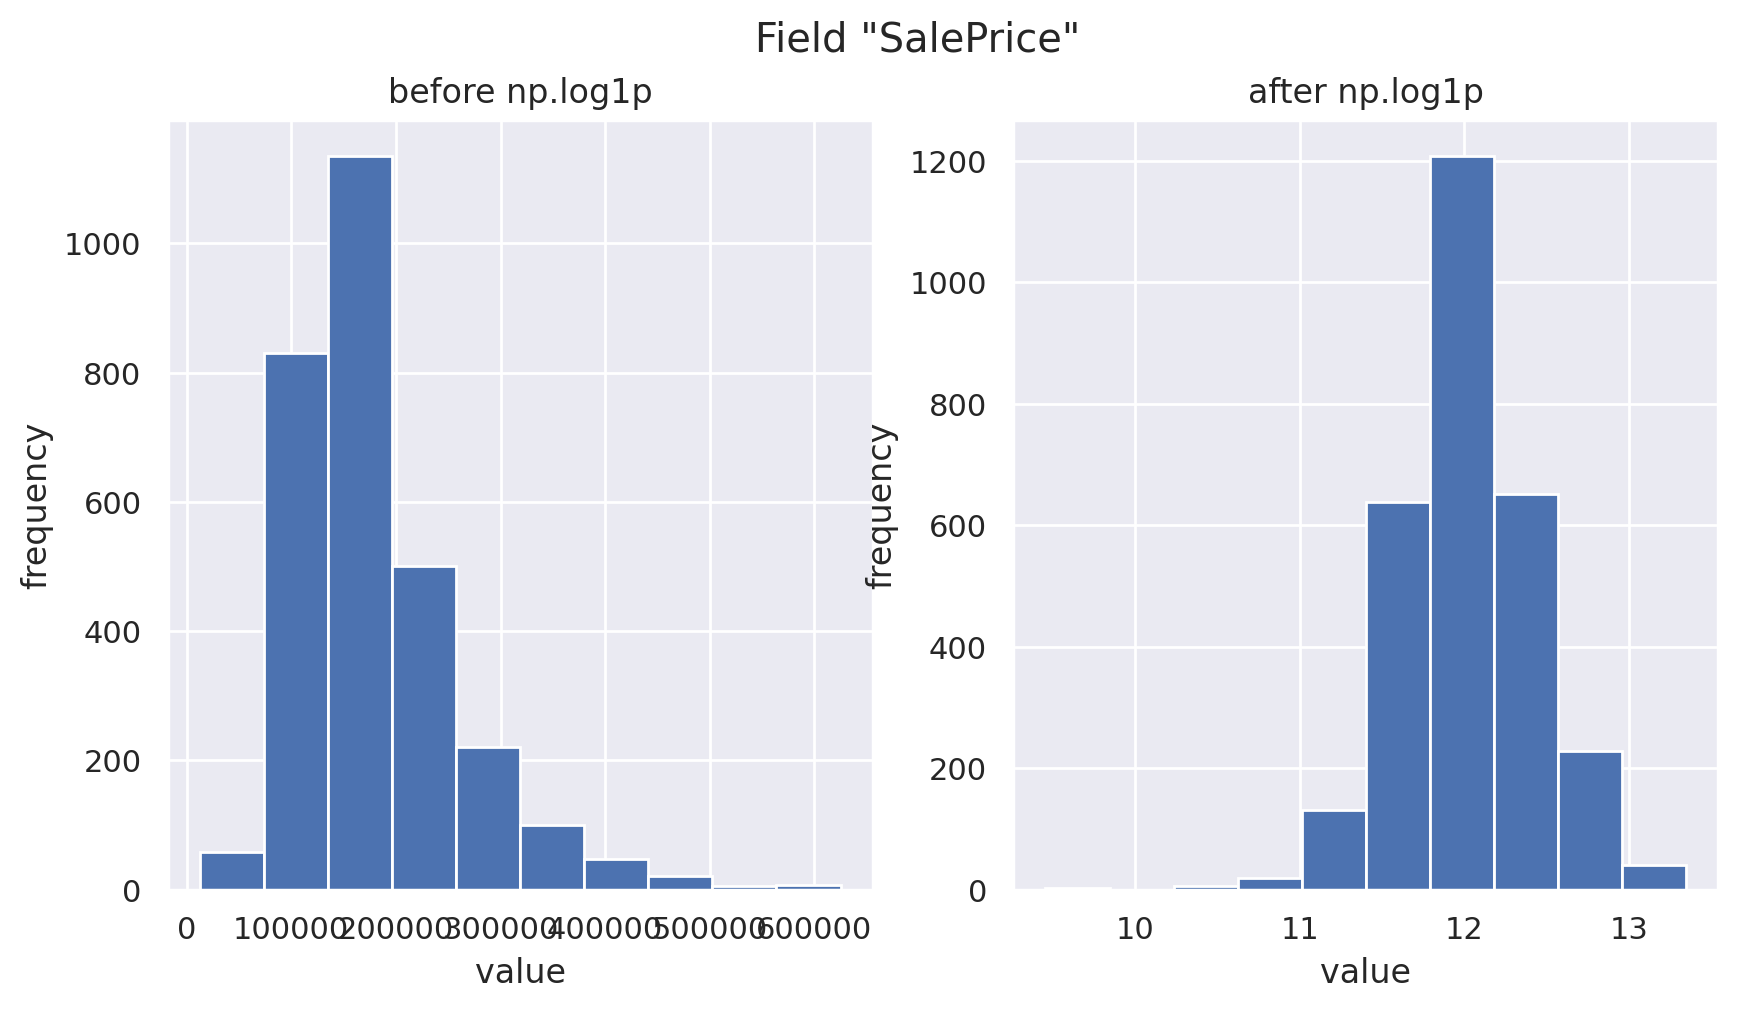

In [145]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "SalePrice"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
df[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
df[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [146]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    if col == "SalePrice":
        continue
    df[col] = df[col].apply(np.log1p)

In [147]:
# We now have a larger set of potentially-useful features
df.shape

(2925, 259)

In [148]:
# There are a *lot* of variables. Let's go back to our saved original data and look at how many values are missing for each variable. 
df = data
data.isnull().sum().sort_values()

Order                0
Sale Condition       0
Heating QC           0
Central Air          0
1st Flr SF           0
                  ... 
Mas Vnr Type      1774
Fence             2354
Alley             2727
Misc Feature      2820
Pool QC           2914
Length: 82, dtype: int64

 Let's pick out just a few numeric columns to illustrate basic feature transformations.

In [149]:
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars','SalePrice']]

In [150]:
# Now we can look at summary statistics of the subset data
smaller_df.describe().T

count           mean           std      min       25%  \
Lot Area        2925.0   10103.583590   7781.999124   1300.0    7438.0   
Overall Qual    2925.0       6.088205      1.402953      1.0       5.0   
Overall Cond    2925.0       5.563761      1.112262      1.0       5.0   
Year Built      2925.0    1971.302906     30.242474   1872.0    1954.0   
Year Remod/Add  2925.0    1984.234188     20.861774   1950.0    1965.0   
Gr Liv Area     2925.0    1493.978803    486.273646    334.0    1126.0   
Full Bath       2925.0       1.564786      0.551386      0.0       1.0   
Bedroom AbvGr   2925.0       2.853675      0.827737      0.0       2.0   
Fireplaces      2925.0       0.596923      0.645349      0.0       0.0   
Garage Cars     2924.0       1.765048      0.759834      0.0       1.0   
SalePrice       2925.0  180411.574701  78554.857286  12789.0  129500.0   

                     50%       75%       max  
Lot Area          9428.0   11515.0  215245.0  
Overall Qual         6.0       7.0      10.0  
Overall Cond         5.0       6.0       9.0  
Year Built        1973.0    2001.0    2010.0  
Year Remod/Add    1993.0    2004.0    2010.0  
Gr Liv Area       1441.0    1740.0    3820.0  
Full Bath            2.0       2.0       4.0  
Bedroom AbvGr        3.0       3.0       8.0  
Fireplaces           1.0       1.0       4.0  
Garage Cars          2.0       2.0       5.0  
SalePrice       160000.0  213500.0  625000.0

In [151]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2924 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [152]:
# There appears to be one NA in Garage Cars - we will take a simple approach and fill it with 0
# note here that we have a single null value in Garage Cars, and perhaps filling it with a 0 is fine
#   but we should be aware of what values we are filling in for different columns.
#   for example, if there were a missing value in Year Built, a 0 would be a poor choice
#   so we could use the mean or median instead
smaller_df = smaller_df.fillna(0)

In [153]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB



### Pair plot of features
Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: pairplot is great for this!

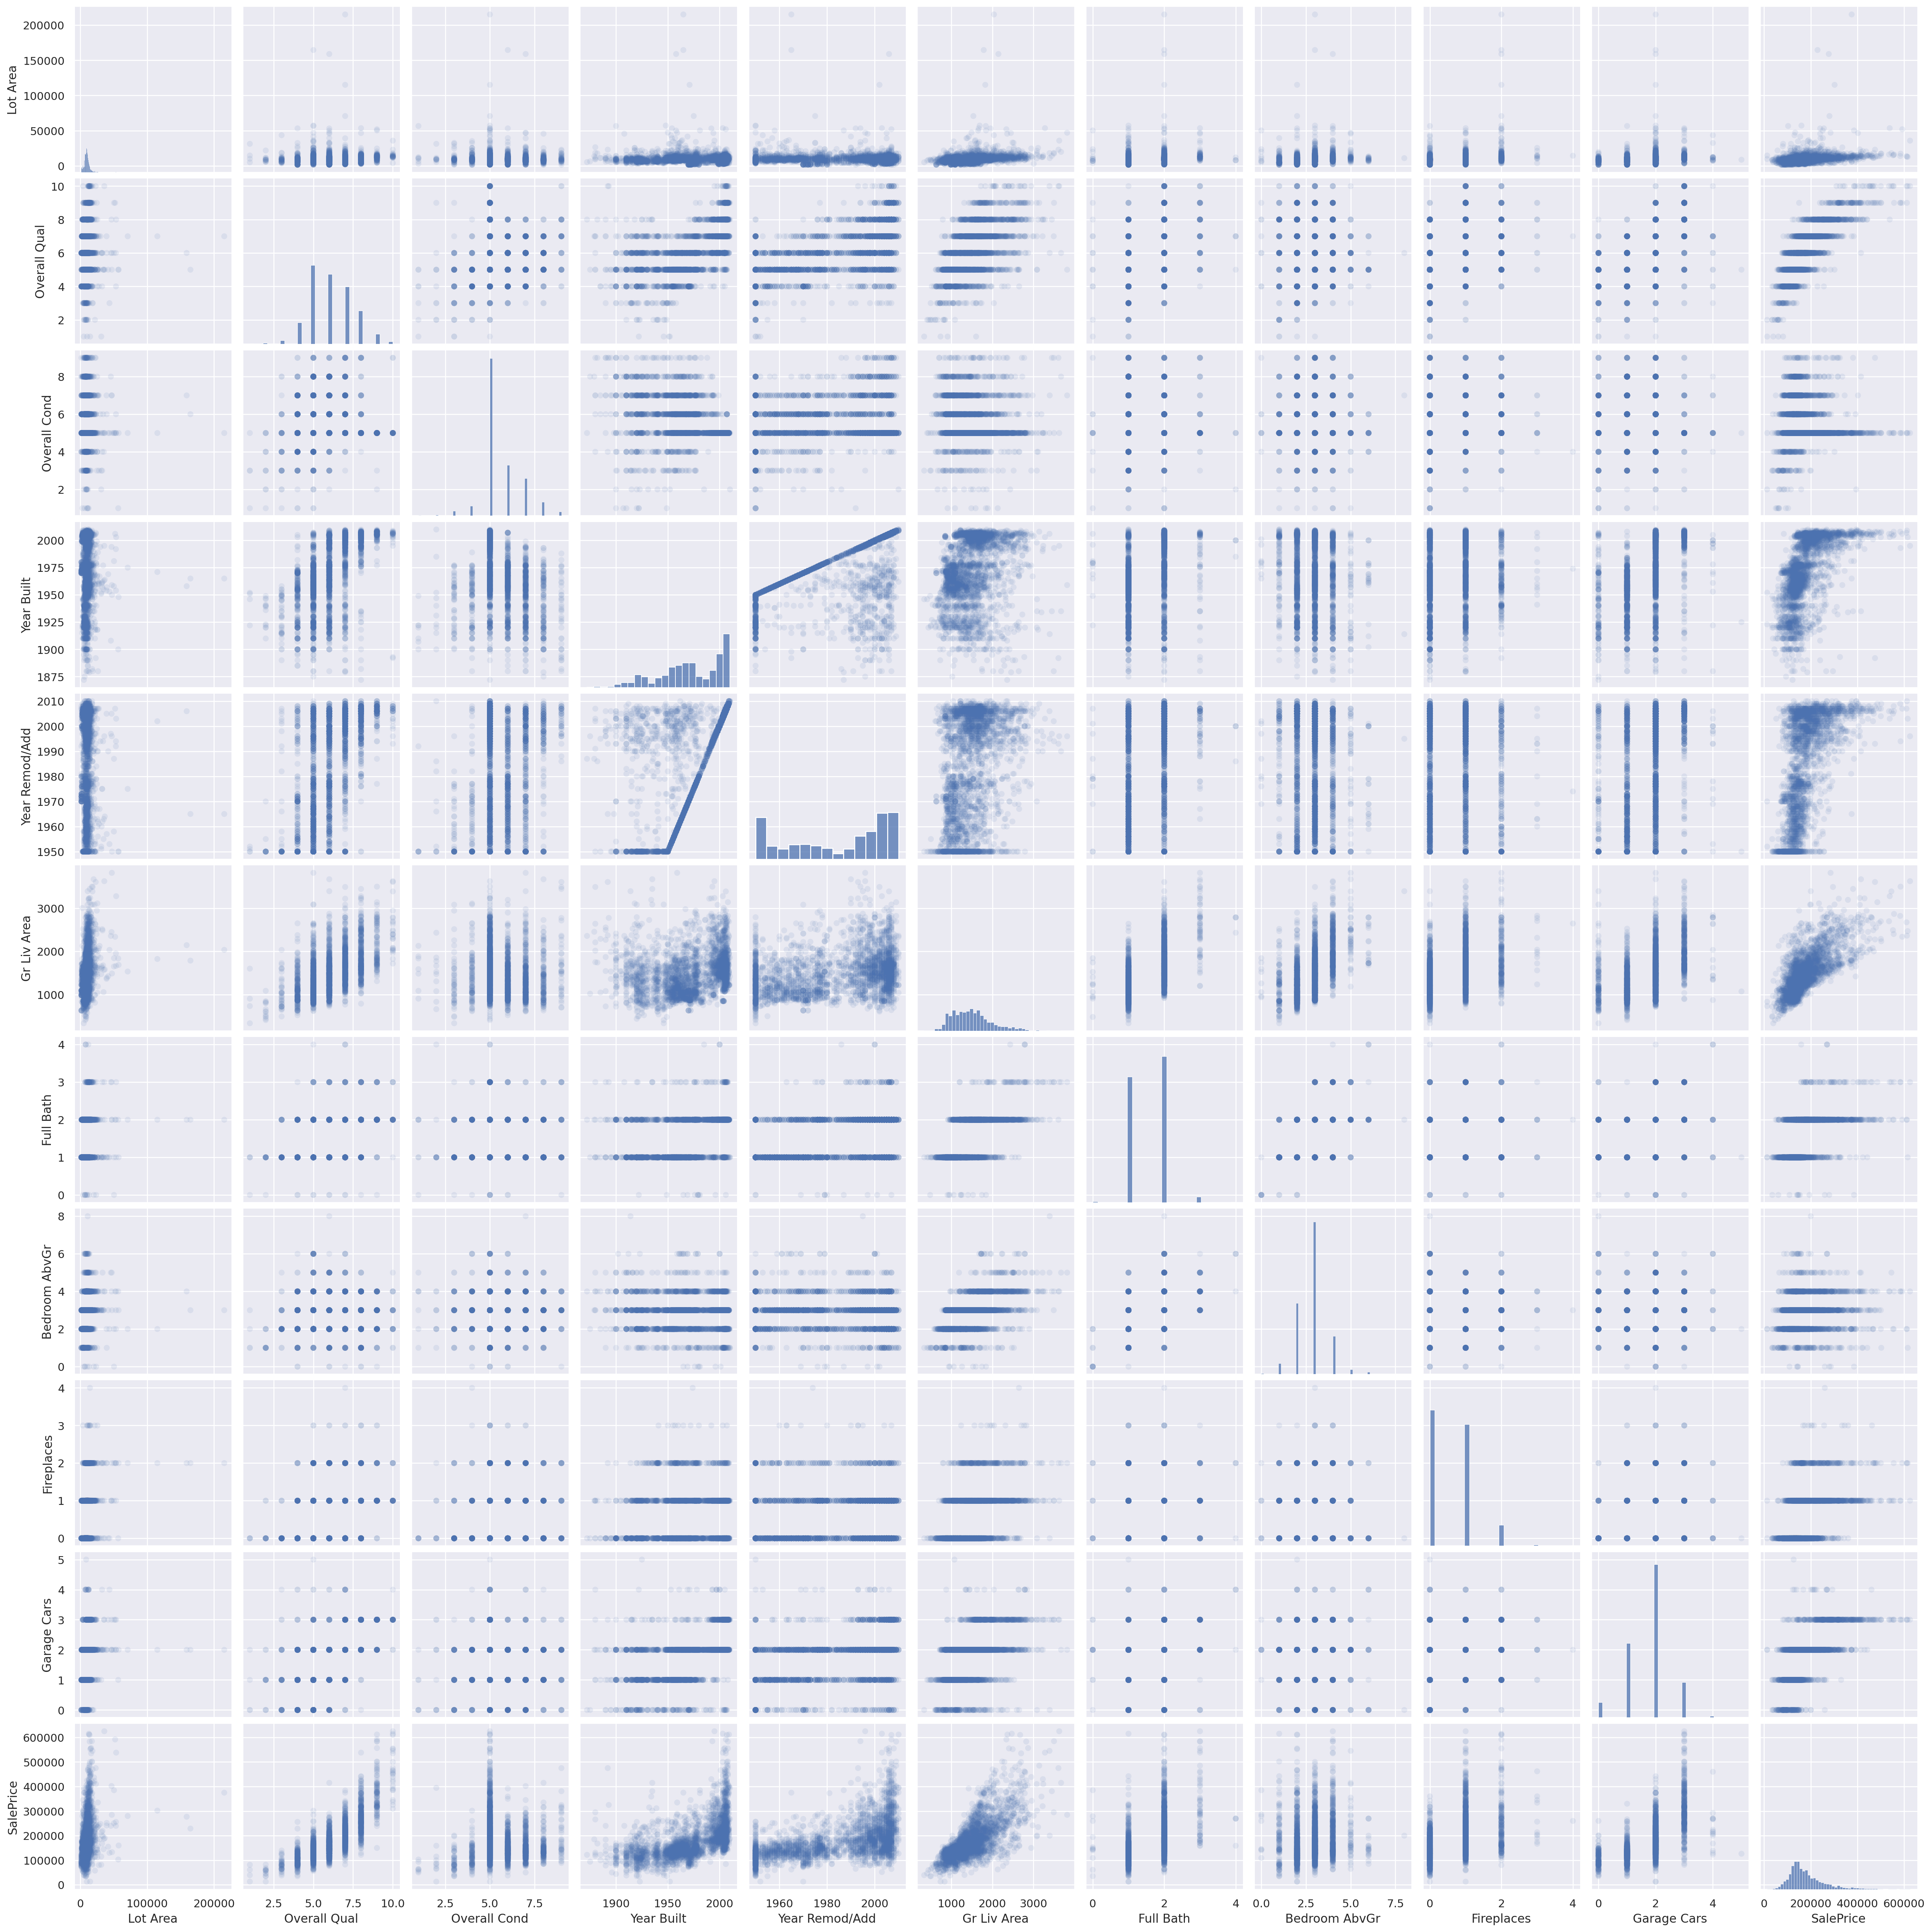

In [154]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

---
**Data Exploration Discussion**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---

#### Suppose our target variable is the SalePrice. We can set up separate variables for features and target.

In [155]:
#Separate our features from our target

X = smaller_df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars']]

y = smaller_df['SalePrice']

In [156]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 251.4 KB


Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

Great, let's go ahead and run this function on our baseline feature set and take some time to analyze the results.

### Basic feature engineering: adding polynomial and interaction terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. 
### Polynomial Features

In [157]:
X2 = X.copy()

X2['OQ2'] = X2['Overall Qual'] ** 2
X2['GLA2'] = X2['Gr Liv Area'] ** 2

As is, each feature is treated as an independent quantity. However, there may be **interaction effects**, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proportions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### Feature interactions

In [158]:
X3 = X2.copy()

# multiplicative interaction
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# division interaction
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']

-----
**Interaction Feature Exercise**: What other interactions do you think might be helpful? Why? 

-----

### Categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

In [159]:
data['House Style'].value_counts()

House Style
1Story    1480
2Story     869
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: count, dtype: int64

This looks ok, and here's a quick look at how dummy features actually appear:

In [160]:
pd.get_dummies(df['House Style'], drop_first=True).head()

1.5Unf  1Story  2.5Fin  2.5Unf  2Story  SFoyer   SLvl
0   False    True   False   False   False   False  False
1   False    True   False   False   False   False  False
2   False    True   False   False   False   False  False
3   False    True   False   False   False   False  False
4   False   False   False   False    True   False  False

We can call `pd.get_dummies()` on our entire dataset to quickly get data with all the original features and dummy variable representation of any categorical features. Let's look at some variable values.

In [161]:
nbh_counts = df.Neighborhood.value_counts()
nbh_counts

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    191
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

For this category, let's map the few least-represented neighborhoods to an "other" category before adding the feature to our feature set and running a new benchmark.

In [162]:
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)

other_nbhs

['Greens', 'GrnHill', 'Landmrk']

In [163]:
X4 = X3.copy()

X4['Neighborhood'] = df['Neighborhood'].replace(other_nbhs, 'Other')

#### Getting to fancier features

Let's close out our introduction to feature engineering by considering a more complex type of feature that may work very nicely for certain problems. It doesn't seem to add a great deal over what we have so far, but it's a style of engineering to keep in mind for the future.

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

Below we define reusable code for generating features of this form, feel free to repurpose it for future feature engineering work!

In [164]:
# This cell provides a visual example of what we are doing in the next cell
X4.groupby('Neighborhood')['Overall Qual'].transform(lambda x: x.std())

0       0.776573
1       0.776573
2       0.776573
3       0.776573
4       0.720823
          ...   
2925    1.048727
2926    1.048727
2927    1.048727
2928    1.048727
2929    1.048727
Name: Overall Qual, Length: 2925, dtype: float64

In [165]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

And now let's use our feature generation code to add 2 new deviation features, and run a final benchmark.

In [166]:
X5 = X4.copy()
X5['House Style'] = df['House Style']
add_deviation_feature(X5, 'Year Built', 'House Style')
add_deviation_feature(X5, 'Overall Qual', 'Neighborhood')

In [167]:
X5

Lot Area  Overall Qual  Overall Cond  Year Built  Year Remod/Add  \
0        31770             6             5        1960            1960   
1        11622             5             6        1961            1961   
2        14267             6             6        1958            1958   
3        11160             7             5        1968            1968   
4        13830             5             5        1997            1998   
...        ...           ...           ...         ...             ...   
2925      7937             6             6        1984            1984   
2926      8885             5             5        1983            1983   
2927     10441             5             5        1992            1992   
2928     10010             5             5        1974            1975   
2929      9627             7             5        1993            1994   

      Gr Liv Area  Full Bath  Bedroom AbvGr  Fireplaces  Garage Cars  OQ2  \
0            1656          1              3           2          2.0   36   
1             896          1              2           0          1.0   25   
2            1329          1              3           0          1.0   36   
3            2110          2              3           2          2.0   49   
4            1629          2              3           1          2.0   25   
...           ...        ...            ...         ...          ...  ...   
2925         1003          1              3           0          2.0   36   
2926          902          1              2           0          2.0   25   
2927          970          1              3           0          0.0   25   
2928         1389          1              2           1          2.0   25   
2929         2000          2              3           1          3.0   49   

         GLA2  OQ_x_YB   OQ_/_LA Neighborhood House Style  \
0     2742336    11760  0.000189        NAmes      1Story   
1      802816     9805  0.000430        NAmes      1Story   
2     1766241    11748  0.000421        NAmes      1Story   
3     4452100    13776  0.000627        NAmes      1Story   
4     2653641     9985  0.000362      Gilbert      2Story   
...       ...      ...       ...          ...         ...   
2925  1006009    11904  0.000756      Mitchel        SLvl   
2926   813604     9915  0.000563      Mitchel      1Story   
2927   940900     9960  0.000479      Mitchel      SFoyer   
2928  1929321     9870  0.000500      Mitchel      1Story   
2929  4000000    13951  0.000727      Mitchel      2Story   

      Year Built_Dev_House Style  Overall Qual_Dev_Neighborhood  
0                      -0.590334                       0.857503  
1                      -0.551186                      -0.430205  
2                      -0.668629                       0.857503  
3                      -0.277154                       2.145211  
4                       0.545208                      -2.101974  
...                          ...                            ...  
2925                    0.505068                       0.434947  
2926                    0.310059                      -0.518590  
2927                    1.096487                      -0.518590  
2928                   -0.042269                      -0.518590  
2929                    0.421480                       1.388483  

[2925 rows x 18 columns]

## Polynomial Features in Scikit-Learn

`sklearn` allows you to build many higher-order terms at once with `PolynomialFeatures`

In [168]:
from sklearn.preprocessing import PolynomialFeatures

In [169]:
#Instantiate and provide desired degree; 
#   Note: degree=2 also includes intercept, degree 1 terms, and cross-terms

pf = PolynomialFeatures(degree=2)

In [170]:
features = ['Lot Area', 'Overall Qual']
pf.fit(df[features])

PolynomialFeatures()

In [173]:
# pf.get_feature_names()  #Must add input_features = features for appropriate names
pf.get_feature_names_out()

array(['1', 'Lot Area', 'Overall Qual', 'Lot Area^2',
       'Lot Area Overall Qual', 'Overall Qual^2'], dtype=object)

In [175]:
feat_array = pf.transform(df[features])
pd.DataFrame(feat_array, columns = pf.get_feature_names_out(input_features=features))

1  Lot Area  Overall Qual    Lot Area^2  Lot Area Overall Qual  \
0     1.0   31770.0           6.0  1.009333e+09               190620.0   
1     1.0   11622.0           5.0  1.350709e+08                58110.0   
2     1.0   14267.0           6.0  2.035473e+08                85602.0   
3     1.0   11160.0           7.0  1.245456e+08                78120.0   
4     1.0   13830.0           5.0  1.912689e+08                69150.0   
...   ...       ...           ...           ...                    ...   
2920  1.0    7937.0           6.0  6.299597e+07                47622.0   
2921  1.0    8885.0           5.0  7.894322e+07                44425.0   
2922  1.0   10441.0           5.0  1.090145e+08                52205.0   
2923  1.0   10010.0           5.0  1.002001e+08                50050.0   
2924  1.0    9627.0           7.0  9.267913e+07                67389.0   

      Overall Qual^2  
0               36.0  
1               25.0  
2               36.0  
3               49.0  
4               25.0  
...              ...  
2920            36.0  
2921            25.0  
2922            25.0  
2923            25.0  
2924            49.0  

[2925 rows x 6 columns]

## Recap

While we haven't yet turned to prediction, these feature engineering exercises set the stage. Generally, feature engineering often follows a sort of [_Pareto principle_](https://en.wikipedia.org/wiki/Pareto_principle), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables can also be very helpful. Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth it depends on the use case for the model. 

---
### Machine Learning Foundation (C) 2020 IBM Corporation